In [311]:
import numpy as np
import pandas as pd
import scipy.signal
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans 
from scipy.ndimage.measurements import center_of_mass

In [6]:
data = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-10houses.csv', 
                header = 0, index_col = 0)
data.index = data.index.map(lambda x: x[:-3])
data.index = pd.to_datetime(data.index)
data = data.astype(np.float64)
data.head()

,dataid,car1,grid
localminute,,,
2017-01-01,26.0,0.005,2.969
2017-01-01,1354.0,0.000,0.266
2017-01-01,114.0,0.000,0.632
2017-01-01,1169.0,0.000,0.469
2017-01-01,379.0,0.005,1.219


In [189]:
week = 7*24*4

In [40]:
ev_signals = pd.DataFrame(index = data[data['dataid'] == data['dataid'][0]].index)
grid_signals = pd.DataFrame(index = data[data['dataid'] == data['dataid'][0]].index)
for i in np.unique(data['dataid']):
    if len(data[data['dataid'] == i]['car1']) == len(ev_signals.index):
        ev_signals[str(i)] = data[data['dataid'] == i]['car1']
        grid_signals[str(i)] = data[data['dataid'] == i]['grid']
    
ev_signals = ev_signals.resample('15T').mean()
ev_signals.fillna(method='backfill',inplace=True)
ev_signals = ev_signals.T

grid_signals = grid_signals.resample('15T').mean()
grid_signals.fillna(method='backfill',inplace=True)
grid_signals = grid_signals.T

N = ev_signals.index.size
grid_signals.head()

localminute,2017-01-01 00:00:00,2017-01-01 00:15:00,2017-01-01 00:30:00,2017-01-01 00:45:00,2017-01-01 01:00:00,2017-01-01 01:15:00,2017-01-01 01:30:00,2017-01-01 01:45:00,2017-01-01 02:00:00,2017-01-01 02:15:00,...,2017-12-31 15:30:00,2017-12-31 15:45:00,2017-12-31 16:00:00,2017-12-31 16:15:00,2017-12-31 16:30:00,2017-12-31 16:45:00,2017-12-31 17:00:00,2017-12-31 17:15:00,2017-12-31 17:30:00,2017-12-31 17:45:00
26.0,2.759267,1.903067,1.472467,1.020333,1.781867,1.765800,0.565000,0.781933,0.741533,0.610000,...,1.251267,0.676133,0.693533,0.756000,0.985200,3.157000,2.694533,2.480733,2.618133,2.347867
114.0,0.632800,0.571400,0.504000,0.499800,0.562000,0.248333,0.385067,0.382933,0.304600,0.307800,...,1.446467,1.664533,1.555400,2.408933,1.502867,1.591200,1.899867,3.006733,2.609200,2.173133
370.0,0.590667,0.597600,0.589933,1.672000,4.321933,4.314667,3.938533,3.784733,1.566333,0.443600,...,1.239333,0.930467,0.770067,0.825667,0.879067,0.611667,0.600200,0.623933,0.627333,0.630933
379.0,1.210467,1.136200,1.022933,1.301000,1.427867,1.006667,0.757400,0.816733,1.409800,1.272200,...,1.295533,0.835333,1.436267,1.414600,1.072400,1.720333,1.629400,1.763267,1.292000,1.744667
1169.0,0.501333,0.464333,0.770467,0.467000,0.514533,0.460733,0.413667,0.340800,0.399533,0.447867,...,0.684467,0.332000,0.259667,0.666933,0.648467,0.717600,0.587067,0.504467,0.567600,0.687067


House number 2


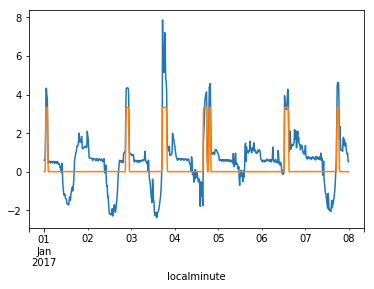

In [42]:
dice = np.random.randint(N)
grid_signals.iloc[dice][:week].plot(alpha=1)
ev_signals.iloc[dice][:week].plot(alpha=1)
print("House number {}".format(dice))
plt.show()

In [99]:
def get_signatures(power_series,min_off_duration = 0, min_on_duration = 3):
    
    signatures = []
    current_signal = []
    starts = []
    peak_times = []
    off_duration = 0
    
    for i in range(1,power_series.size):

        if power_series[i] > 1:
            if len(current_signal) == 0:
                current_signal.append(0)
            current_signal.append(power_series[i])
            off_duration = 0
        else:
            off_duration += 1
            if off_duration >= min_off_duration and len(current_signal) > min_on_duration:
                current_signal.append(0)
                signatures.append(current_signal)
                starts.append(power_series.index[i-len(current_signal)])
                peak_times.extend(power_series.index[i-len(current_signal):i])
                current_signal = []
            
    return signatures, starts, pd.to_datetime(peak_times)

def make_templates_2(signatures, significance = 10, n_templates = 2):
    n = len(signatures)
    signatures_by_length = []
    templates = []
    if n == 0:
        return []
    
    #create array where the ith element is an array containing all the length i signatures.
    for i in range(np.max([len(s) for s in signatures])):
        length_n_signatures = [s for s in signatures if len(s) == i]
        
        if len(length_n_signatures) > significance: #significance criterium
            signatures_by_length.append(length_n_signatures)
        
    kmeans = KMeans(n_clusters=n_templates)

    for length_n_signatures in signatures_by_length:
        cluster_indices = kmeans.fit_predict(length_n_signatures)
        length_n_templates = []
        
        for i in range(n_templates):
            cluster = [length_n_signatures[j] for j in range(len(length_n_signatures)) if cluster_indices[j] == i]
            template = np.array(np.sum(cluster, axis=0))
            template /= len(cluster)
            length_n_templates.append(template)
        
        templates.extend(length_n_templates)
    
    return templates

In [144]:
signatures = []
signal_starts = []
signal_times = []

for i in range(N):
    signal, start, time = get_signatures(ev_signals.iloc[i])
    signatures.extend(signal)
    signal_starts.append(start)
    signal_times.append(time)


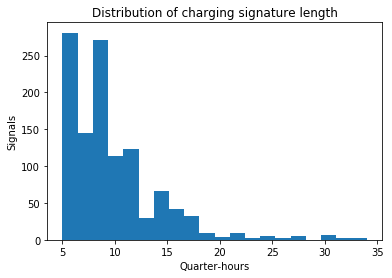

In [77]:
plt.hist([len(s) for s in signatures],bins=20)
plt.title("Distribution of charging signature length")
plt.xlabel("Quarter-hours")
plt.ylabel("Signals")
plt.show()

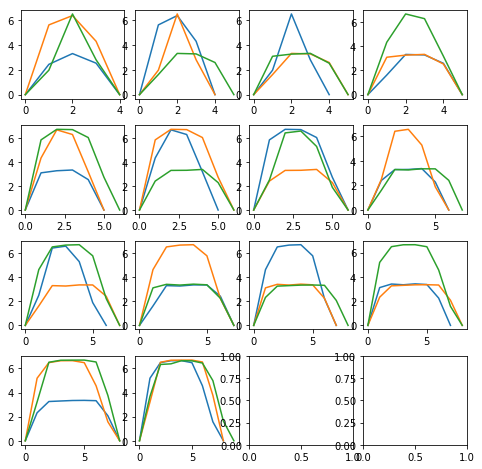

In [203]:
n_templates = 3

templates = make_templates_2(signatures,n_templates=n_templates)

fig,axarr = plt.subplots(4,4,sharex=False)
plt.subplots_adjust(hspace=0.3,wspace=0.1)
fig.set_size_inches(8,8)

for i in range(int(len(templates)/n_templates)):
    for j in range(n_templates):
        axarr[int(np.floor((i)/4)),int((i)%4)].plot(templates[i+j])
    #axarr[int(np.floor((i)/6)),int((i)%6)].set_title("Average " + str((i-1)/4) + " hour signature")
plt.show()

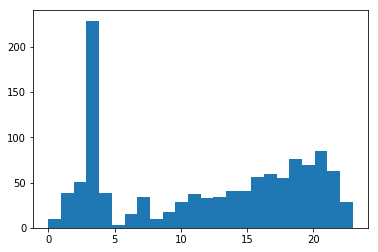

In [143]:
plt.hist([time.hour for starts in signal_starts for time in starts],bins=24)
plt.show()

Except for the spike at 3AM, this makes sense.

In [329]:
def find_signals(data, templates, threshold=0.4, mode='same', interval = 10):
    #Finds the events corresponding to a cross correlation between the data and at least one template of above threshold.

    timeline = pd.DataFrame(np.zeros(data.shape[0]),index = data.index)
    for template in templates:
        
        if sum(template) == 0:
            continue
            
        xcorr = scipy.signal.correlate(data, template, mode=mode)
        xcorr /= xcorr.max()

        i=0        
        while i < len(xcorr):
            if xcorr[i] >= threshold:
                timeline.loc[data.index[i]] += 1
            i+=1
        
        
    i=0
    while i < len(timeline):
        start = i
        if timeline.iloc[i][0] > 0:
            while i < len(timeline) and timeline.iloc[i][0] > 0:
                #timeline.iloc[i][0] = 0
                i+=1
            #it is important for the testing that the middle of the signal is labeled
            signal_center = start + int(center_of_mass(timeline.iloc[start:i][0])[0])
            timeline.iloc[start:i] -= timeline.iloc[start:i]
            timeline.iloc[signal_center] +=1
            #timeline.iloc[int((i+start)/2)] += 1 
        else:
            i+=1
    
    return timeline.where(timeline > 0).dropna().index

In [148]:
def filter_score(signal_times,signals_hat,n_signals):
    #True positives
    tp = np.where(np.in1d(signals_hat,signal_times))[0].shape[0]
    #False positives
    fp = np.where(np.in1d(signals_hat,signal_times,invert=True))[0].shape[0]
    #Precision
    precision = tp/(tp+fp)
    #Recall
    recall = tp/n_signals
    #F1-measure
    f1 = (2*precision*recall) / (precision + recall)
    #print('Precision: {}\nRecall: {}\nF1-score: {}'.format(precision,recall,f1))
    
    return precision,recall,f1

In [186]:
test_data = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev2.csv', 
                header = 0, index_col = 0)
test_data.index = test_data.index.map(lambda x: x[:-3])
test_data.index = pd.to_datetime(test_data.index)
test_data = test_data.resample('15T').mean()
test_data['grid'][np.isnan(test_data['grid'])] = np.zeros(len(test_data['grid'][np.isnan(test_data['grid'])]))
test_data.head()

,dataid,car1,grid
localminute,,,
2017-01-01 00:00:00,3482.0,0.000000,0.247200
2017-01-01 00:15:00,3482.0,0.006400,0.208600
2017-01-01 00:30:00,3482.0,0.000733,0.227933
2017-01-01 00:45:00,3482.0,0.005600,0.139133
2017-01-01 01:00:00,3482.0,0.006333,0.199867


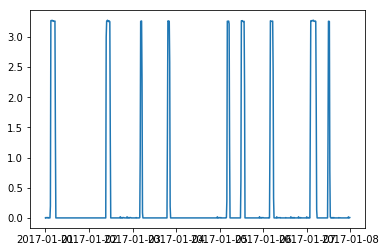

In [190]:
plt.plot(test_data['car1'][:week])
plt.show()

In [191]:
test_signatures, test_signal_starts, test_signal_times = get_signatures(test_data['car1'])

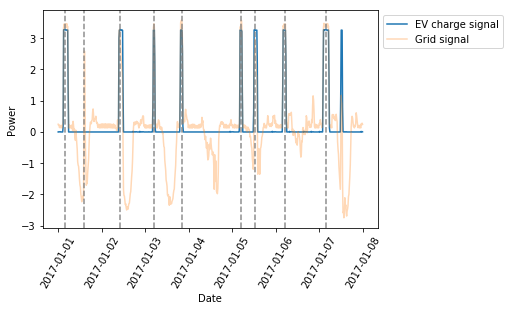

In [332]:
%%prun
signals = find_signals(test_data['grid'][:week], [templates[i] for i in range(len(templates))],threshold=0.4)

plt.plot(test_data['car1'][:week])
plt.plot(test_data['grid'][:week],alpha = 0.3)
plt.ylabel("Power")
plt.xlabel("Date")
plt.legend(["EV charge signal","Grid signal"],bbox_to_anchor=(1, 1))
plt.xticks(rotation=60)
for line in signals:
    plt.axvline(line, linestyle='--',alpha=0.9,color='grey')

plt.show()

In [333]:
precisions1 = []
recalls1 = []
f1s1 = []
threshold_range = np.linspace(0.3,0.8,10)

for i in threshold_range:
    s = find_signals(test_data['grid'], [template for template in templates],threshold=i)
    p,r,f1 = filter_score(test_signal_times,s,len(test_signal_starts))
    precisions1.append(p)
    recalls1.append(r)
    f1s1.append(f1)

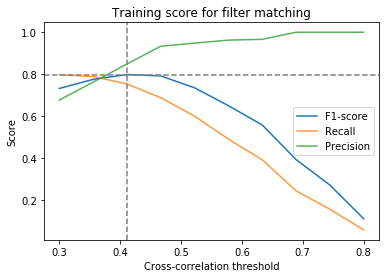

Max F1: 0.7988422575976845


In [334]:

plt.plot(threshold_range, f1s1)
plt.plot(threshold_range, recalls1, alpha=0.8)
plt.plot(threshold_range, precisions1, alpha=0.8)
plt.title("Training score for filter matching")
plt.legend(["F1-score","Recall","Precision"])
plt.axhline(np.max(f1s1), color='grey', linestyle='--')
plt.axvline(threshold_range[np.argmax(f1s1)], color='grey', linestyle='--')
plt.xlabel("Cross-correlation threshold")
plt.ylabel("Score")
plt.show()
print("Max F1: {}".format(np.max(f1s1)))